the most common question a indivual asks when investing in a company is "is this company a good acquistion or investment target?". to answer this question the most of us have access to the companies financial statements aka balance sheet, income statement and cash flow statements. when analzing the statements a individual is alaways asking is the statement accruate aka is there fraud in the statement or companies operations? the code below is going to attempt to a build a classifier that will tell us the probabality of the statement being fraudlent or not

cash vs current liablity will give us information if the company genrates enough money to pay for daily operations
total liablites vs assests will tell us is the companies assests are enough to cover all liablities
sales/fixed assets will tell if the companies sales justify the assests being generated


In [49]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from scipy.stats import linregress

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
companies = pd.read_csv("../dataset/companies.csv")
companies.head()
len(list(companies.name_latest.unique())) #12146
companies.shape
#27 duplicates
#companies[companies.names_previous.notnull()]
#by matching previous names to current names it may be possible to fill in some of the null values
#a=[]
#for c in companies[companies.names_previous.notnull()].names_previous:
#    a.append(companies[companies.name_latest.str.lower() == c.lower()])
#a
#Companies with multiple company ID
companies[companies.duplicated('name_latest',keep=False)].sort_values(by='name_latest')

,company_id,name_latest,names_previous
6067,1498068,"American Renal Associates Holdings, Inc.",NaN
6678,1525040,"American Renal Associates Holdings, Inc.",NaN
9017,1672909,Canterbury Park Holding Corp,NaN
11879,926761,Canterbury Park Holding Corp,NaN
5430,1462694,"Connectone Bancorp, Inc.",NaN
9848,712771,"Connectone Bancorp, Inc.",Center Bancorp Inc
4133,1389030,Crestwood Midstream Partners LP,NaN
2916,1304464,Crestwood Midstream Partners LP,"Inergy Midstream, L.P."
9377,351231,Dawson Geophysical CO,NaN
10492,799165,Dawson Geophysical CO,TGC Industries Inc


In [3]:
json_company = pd.read_json("../dataset/companies.json")
json_company.head()
json_company.shape
#its looks like the same files as the csv file ignore this data frame

(12173, 3)

In [4]:
indicators = pd.read_csv("../dataset/indicators_by_company.csv")
indicators.head()
indicators.shape

(1907883, 9)

In [5]:
indicators.isnull().sum()
#most of the inidcators are null on 2010 and 2016. considering dropping. by row or/and by column?

company_id            0
indicator_id          0
2010            1874560
2011            1113384
2012             776075
2013             776786
2014             768212
2015             858750
2016            1906296
dtype: int64

In [6]:
df = pd.merge(companies,indicators,how='outer',on='company_id')
df.head()

,company_id,name_latest,names_previous,indicator_id,2010,2011,2012,2013,2014,2015,2016
0,1000045,Nicholas Financial Inc,NaN,AccountsPayableAndAccruedLiabilitiesCurrentAnd...,NaN,6612429.0,7405579.0,8924919.0,7841070.0,5839000.0,NaN
1,1000045,Nicholas Financial Inc,NaN,AccumulatedDepreciationDepletionAndAmortizatio...,NaN,NaN,2111343.0,2242703.0,2236449.0,2462000.0,NaN
2,1000045,Nicholas Financial Inc,NaN,AdjustmentForAmortization,NaN,NaN,-11482251.0,-13490892.0,-13852305.0,-13811000.0,NaN
3,1000045,Nicholas Financial Inc,NaN,Assets,NaN,257236034.0,263835468.0,283429579.0,302528591.0,325309000.0,NaN
4,1000045,Nicholas Financial Inc,NaN,AssetsHeldForSaleAtCarryingValue,NaN,1373001.0,1203664.0,1696330.0,NaN,NaN,NaN


In [7]:
# Number of Indicators by company
ind_count_company = pd.DataFrame()
for year in range(2010,2017,1):
    ind_count_company[year] = df[['company_id', 'indicator_id', str(year)]].dropna().groupby('company_id')['indicator_id'].count().sort_values(ascending=False)

ind_count_company.head()

,2010,2011,2012,2013,2014,2015,2016
company_id,,,,,,,
12659,342,342.0,343.0,330.0,322.0,268.0,NaN
40704,327,333.0,310.0,309.0,324.0,328.0,NaN
826083,290,300.0,320.0,NaN,NaN,NaN,NaN
8670,290,277.0,292.0,295.0,301.0,294.0,NaN
800459,289,291.0,271.0,290.0,288.0,268.0,NaN


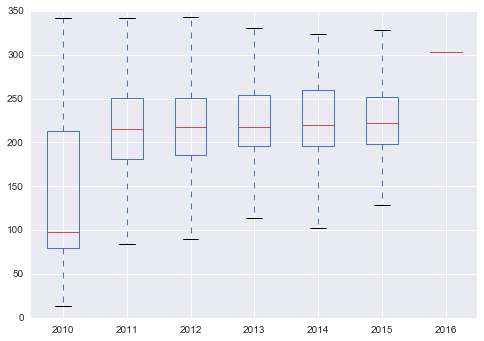

In [8]:
ind_count_company.plot.box()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010A2A048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000CA29358>]], dtype=object)

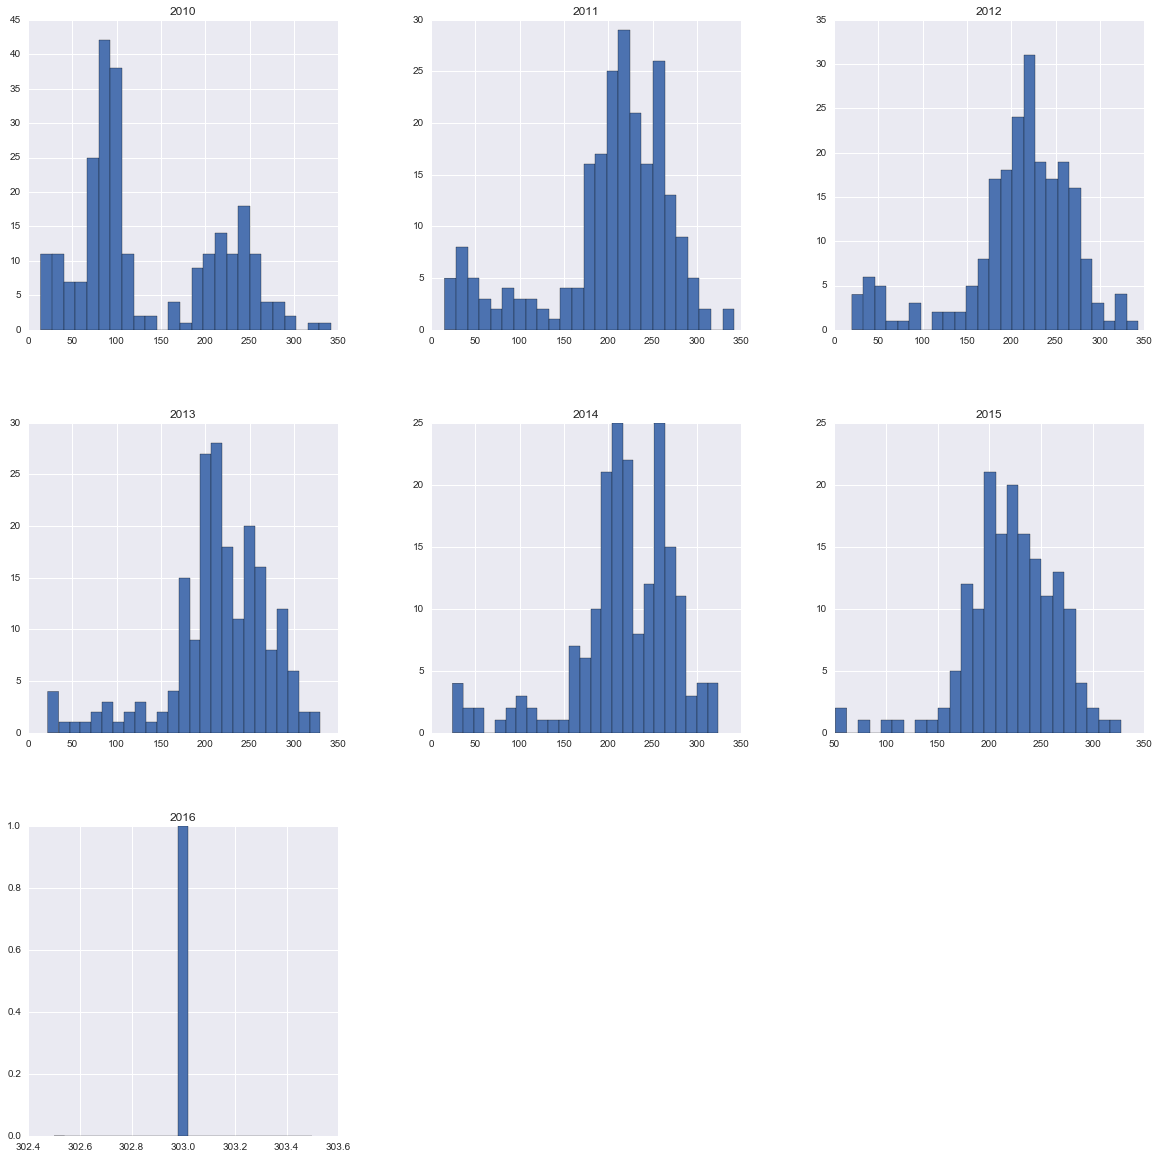

In [9]:
ind_count_company.hist(bins=25,figsize=(20,20))

In [10]:
#since the number of indicators can vary lets find the most common indicators across all the years
company_count = []
for year in range(2010,2017,1):
    company_count.append(df[['company_id', 'indicator_id', str(year)]].dropna().groupby('indicator_id')['company_id'].count().sort_values(ascending=False))
company_count_ind = pd.concat(company_count,axis = 1)
company_count_ind.columns=['2010','2011','2012','2013','2014','2015','2016']
company_count_ind.head()

,2010,2011,2012,2013,2014,2015,2016
AcceleratedShareRepurchaseProgramAdjustment,NaN,2.0,3.0,4.0,9.0,3.0,NaN
AcceleratedShareRepurchasesAdjustmentToRecordedAmount,NaN,NaN,NaN,1.0,NaN,1.0,NaN
AcceleratedShareRepurchasesFinalPricePaidPerShare,NaN,2.0,6.0,8.0,8.0,12.0,NaN
AcceleratedShareRepurchasesInitialPricePaidPerShare,NaN,1.0,1.0,2.0,2.0,1.0,NaN
AcceleratedShareRepurchasesSettlementPaymentOrReceipt,1.0,8.0,3.0,5.0,5.0,4.0,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CBB3E80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000107FCC18>]], dtype=object)

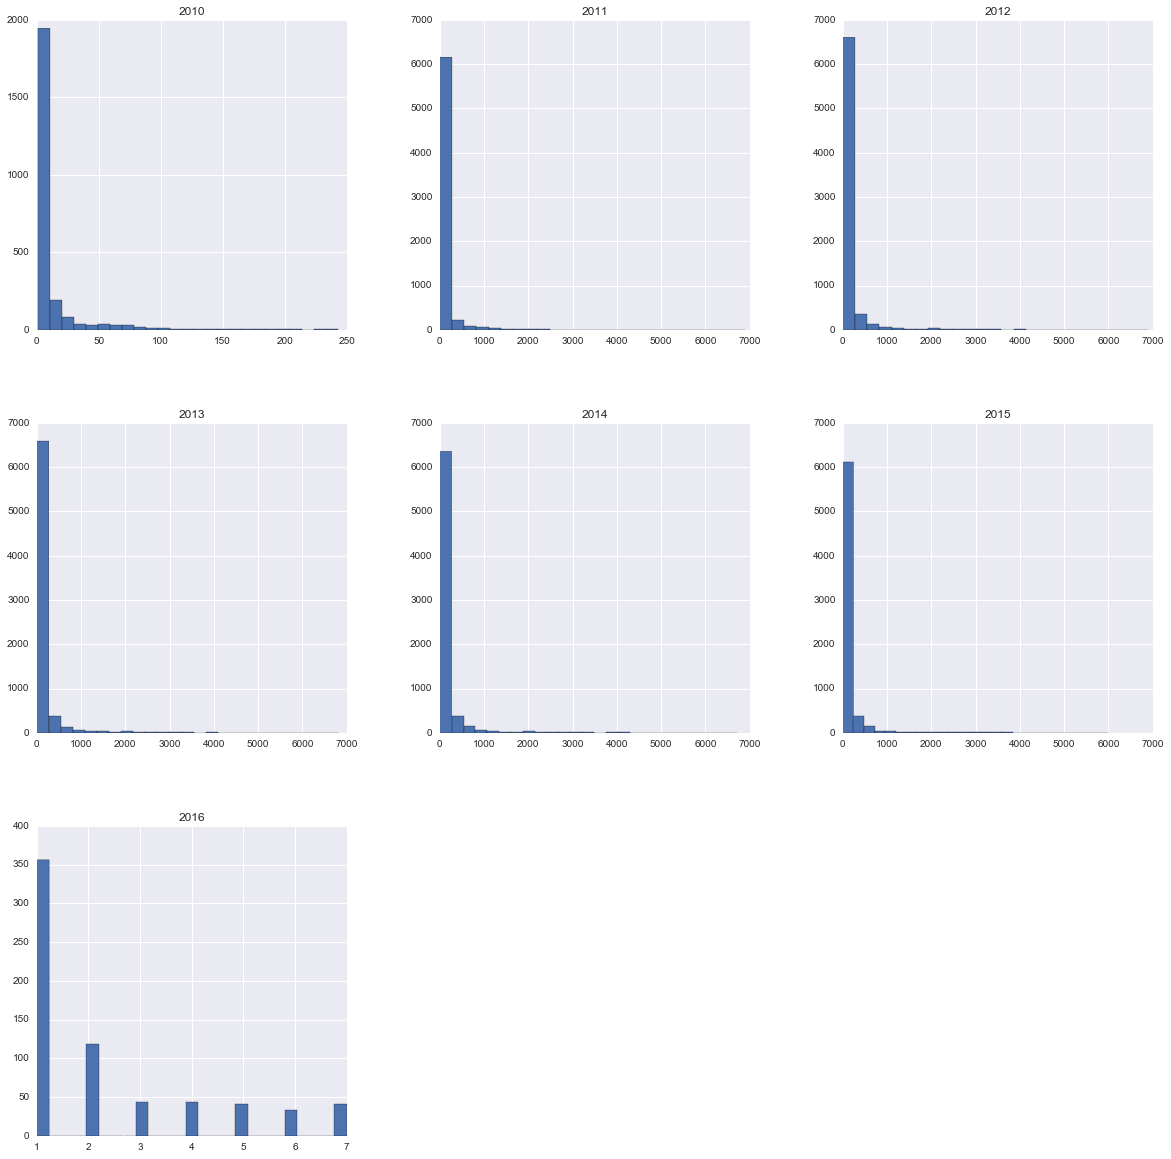

In [11]:
company_count_ind.hist(bins=25,figsize = (20,20))
#counts of indicators are less in 2010 and 2016. we will be dropping them

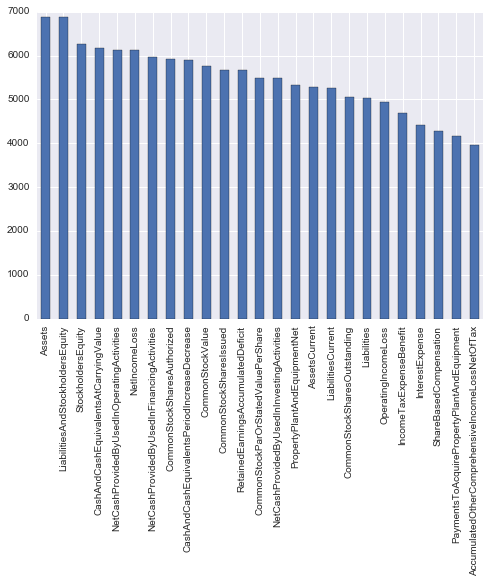

In [12]:
company_count_ind['2011'].sort_values(ascending=False).head(25).plot('bar')

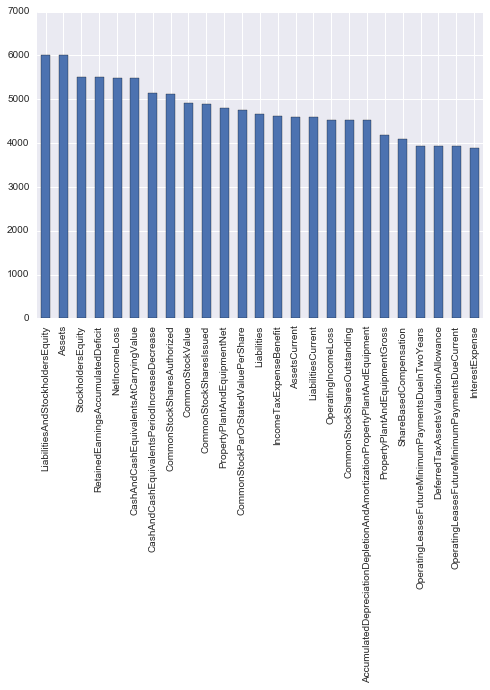

In [13]:
company_count_ind['2015'].sort_values(ascending=False).head(25).plot('bar')
# there are approximaltely 4000 common companies in the top 25 indicators for both 2011 and 2015.

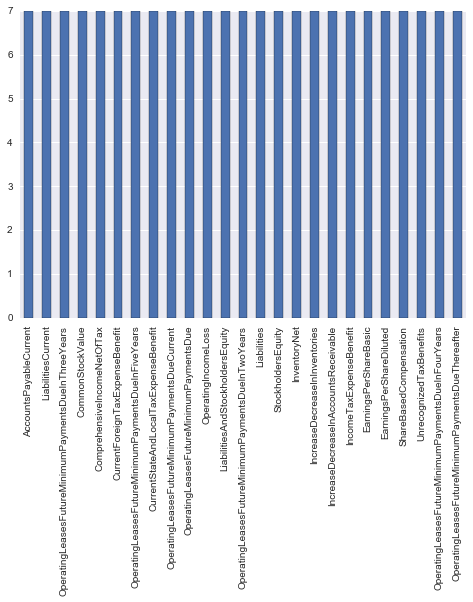

In [14]:
company_count_ind['2016'].sort_values(ascending=False).head(25).plot('bar')

In [15]:
#build a list of common indicators across all years using the base list of 2015
common_indicators = company_count_ind['2015'].sort_values(ascending=False).index[0:25]
for a in ['2014','2013','2012','2011']:
    indicators1 = company_count_ind[a].sort_values(ascending=False).index[0:25]
    common_indicators = common_indicators.intersection(indicators1)
len(common_indicators.tolist())
common_indicators
#after starting with 25 indicators in each year we ended with 20 common indicators for 5 years

Index([u'Assets', u'LiabilitiesAndStockholdersEquity', u'StockholdersEquity',
       u'CashAndCashEquivalentsAtCarryingValue', u'NetIncomeLoss',
       u'CommonStockSharesAuthorized',
       u'CashAndCashEquivalentsPeriodIncreaseDecrease', u'CommonStockValue',
       u'CommonStockSharesIssued', u'RetainedEarningsAccumulatedDeficit',
       u'CommonStockParOrStatedValuePerShare', u'PropertyPlantAndEquipmentNet',
       u'AssetsCurrent', u'LiabilitiesCurrent',
       u'CommonStockSharesOutstanding', u'Liabilities', u'OperatingIncomeLoss',
       u'IncomeTaxExpenseBenefit', u'InterestExpense',
       u'ShareBasedCompensation'],
      dtype='object')

In [16]:
#find all companies with these 20 indicators and not null values for all 5 years
companies_list = []
for year in ['2015','2014','2013','2012','2011']:
    common_companies = df[((df.indicator_id == common_indicators[0]) & (df[year].notnull()))]['company_id'].unique()
    for i in range(1,len(common_indicators)):
        companies1 = df[((df.indicator_id == common_indicators[i]) & (df[year].notnull()))]['company_id'].unique()
        common_companies = np.intersect1d(common_companies,companies1)
        companies_list.append(common_companies)

In [17]:
#build a dataframe with indicators as column and companies&year as row.
#common_list = []
#for year in ['2011','2012','2013','2014','2015']:
#    for c in range(0,len(companies_list)):
#        temp = df[((df.indicator_id.isin(common_indicators)) & (df.company_id.isin(companies_list[c])))][['company_id','indicator_id',str(year)]].dropna(axis=0,how='any')
#        temp = temp.pivot(index='company_id',columns='indicator_id',values=str(year))
#        temp['year']=year
#        common_list.append(temp)
#common = pd.concat(common_list)

In [18]:
#build a dataframe with indicators as column and companies&year as row.
common_list = []
for year in ['2011','2012','2013','2014','2015']:
    temp = df[((df.indicator_id.isin(common_indicators)))][['company_id','indicator_id',str(year)]].dropna(axis=0,how='any')
    temp = temp.pivot(index='company_id',columns='indicator_id',values=str(year))
    temp['year']=year
    common_list.append(temp)
common = pd.concat(common_list)
common.shape

(34078, 21)

In [19]:
common.head()

indicator_id,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,CashAndCashEquivalentsPeriodIncreaseDecrease,CommonStockParOrStatedValuePerShare,CommonStockSharesAuthorized,CommonStockSharesIssued,CommonStockSharesOutstanding,CommonStockValue,IncomeTaxExpenseBenefit,...,Liabilities,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,NetIncomeLoss,OperatingIncomeLoss,PropertyPlantAndEquipmentNet,RetainedEarningsAccumulatedDeficit,ShareBasedCompensation,StockholdersEquity,year
company_id,,,,,,,,,,,,,,,,,,,,,
1750,2.195653e+09,1.063272e+09,6.772000e+07,NaN,1.00,1.000000e+08,4.484900e+07,NaN,44849000.0,25480000.0,...,NaN,2.195653e+09,4.732260e+08,67723000.0,NaN,3.829330e+08,5.417720e+08,12546000.0,8.646490e+08,2011
1800,6.027689e+10,2.376877e+10,6.812820e+09,3.164449e+09,NaN,2.400000e+09,1.638870e+09,NaN,NaN,470193000.0,...,NaN,6.027689e+10,1.548023e+10,NaN,5.751948e+09,7.873955e+09,2.090736e+10,382602000.0,2.443983e+10,2011
2034,2.992800e+08,1.919690e+08,2.486200e+07,-3.802000e+06,0.01,4.000000e+07,2.693700e+07,26937000.0,269000.0,7759000.0,...,131277000.0,2.992800e+08,7.364100e+07,16981000.0,2.536600e+07,1.170500e+07,1.023440e+08,1168000.0,1.680030e+08,2011
2098,5.522174e+07,4.652236e+07,7.853343e+06,1.251927e+06,2.50,8.000000e+06,4.454024e+06,NaN,11134303.0,1214827.0,...,27446809.0,5.522174e+07,8.704020e+06,2811193.0,4.284964e+06,2.506124e+06,2.440302e+07,428439.0,2.777493e+07,2011
2178,3.788400e+08,3.049650e+08,3.706600e+07,8.034000e+06,0.10,7.500000e+06,4.217596e+06,4217596.0,422000.0,12831000.0,...,268158000.0,3.788400e+08,2.560940e+08,22931000.0,3.553300e+07,6.923500e+07,9.856700e+07,NaN,1.106820e+08,2011


In [20]:
common.tail()

indicator_id,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,CashAndCashEquivalentsPeriodIncreaseDecrease,CommonStockParOrStatedValuePerShare,CommonStockSharesAuthorized,CommonStockSharesIssued,CommonStockSharesOutstanding,CommonStockValue,IncomeTaxExpenseBenefit,...,Liabilities,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,NetIncomeLoss,OperatingIncomeLoss,PropertyPlantAndEquipmentNet,RetainedEarningsAccumulatedDeficit,ShareBasedCompensation,StockholdersEquity,year
company_id,,,,,,,,,,,,,,,,,,,,,
1653876,38319.0,37782.0,NaN,NaN,0.001,75000000.0,3785000.0,3785000.0,3785.0,0.0,...,16719.0,38319.0,16719.0,-24045.0,NaN,537.0,-42336.0,NaN,21600.0,2015
1655008,3369.0,3369.0,3369.0,2991.0,0.100,750000.0,210281.0,210281.0,21028.0,NaN,...,3186.0,3369.0,3186.0,-9.0,-10.0,NaN,-201098.0,NaN,183.0,2015
1658432,1921278.0,927310.0,316603.0,205004.0,0.001,500000000.0,3000000.0,3000000.0,3000.0,NaN,...,1975473.0,1921278.0,1800130.0,-88708.0,-232769.0,993968.0,-241690.0,NaN,-54195.0,2015
1660156,1482.0,1482.0,127.0,127.0,0.000,100000000.0,3580000.0,3580000.0,358.0,NaN,...,81733.0,1482.0,81733.0,-80451.0,-80451.0,NaN,-80609.0,NaN,NaN,2015
1666114,7197.0,6302.0,5158.0,-9356.0,0.001,100000000.0,15000000.0,15000000.0,15000.0,NaN,...,3645.0,7197.0,3645.0,-11544.0,NaN,895.0,-13817.0,NaN,3552.0,2015


In [32]:
df2015 = df[df.indicator_id.isin(common_indicators)][['company_id','indicator_id','2015']]
df2015 = df2015.pivot(index='company_id',columns='indicator_id',values = '2015').dropna()
df2015.head()

indicator_id,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,CashAndCashEquivalentsPeriodIncreaseDecrease,CommonStockParOrStatedValuePerShare,CommonStockSharesAuthorized,CommonStockSharesIssued,CommonStockSharesOutstanding,CommonStockValue,IncomeTaxExpenseBenefit,InterestExpense,Liabilities,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,NetIncomeLoss,OperatingIncomeLoss,PropertyPlantAndEquipmentNet,RetainedEarningsAccumulatedDeficit,ShareBasedCompensation,StockholdersEquity
company_id,,,,,,,,,,,,,,,,,,,,
2034,5.407780e+08,3.526610e+08,66828000.0,32808000.0,0.01,75000000.0,29595000.0,29595000.0,296000.0,19088000.0,6997000.0,2.363360e+08,5.407780e+08,9.890600e+07,3.476600e+07,5.802800e+07,1.004400e+07,1.948040e+08,6719000.0,3.044420e+08
2969,1.743810e+10,2.910800e+09,206400000.0,-130200000.0,1.00,300000000.0,249455584.0,215359113.0,249400000.0,415900000.0,103500000.0,1.005700e+10,1.743810e+10,3.648100e+09,1.277900e+09,1.699100e+09,9.636900e+09,1.058040e+10,45700000.0,7.249000e+09
3545,4.605800e+08,7.068000e+07,7360000.0,-23660000.0,1.00,15000000.0,8416145.0,8325580.0,8416000.0,10905000.0,8373000.0,2.829810e+08,4.605800e+08,2.363300e+07,1.573300e+07,1.905900e+07,3.816670e+08,1.470490e+08,1126000.0,1.727920e+08
7039,2.588110e+08,6.635300e+07,18623000.0,10117000.0,0.10,40000000.0,24200000.0,24200000.0,2416000.0,9764000.0,2217000.0,1.164260e+08,2.588110e+08,2.294700e+07,1.859800e+07,3.604100e+07,9.690700e+07,8.901800e+07,2353000.0,1.420960e+08
8947,9.833710e+08,3.093340e+08,40191000.0,17664000.0,1.00,100000000.0,25873690.0,25873690.0,25874000.0,27578000.0,15155000.0,5.021550e+08,9.833710e+08,1.484050e+08,7.679000e+07,1.222880e+08,2.263330e+08,4.507540e+08,4538000.0,4.812160e+08


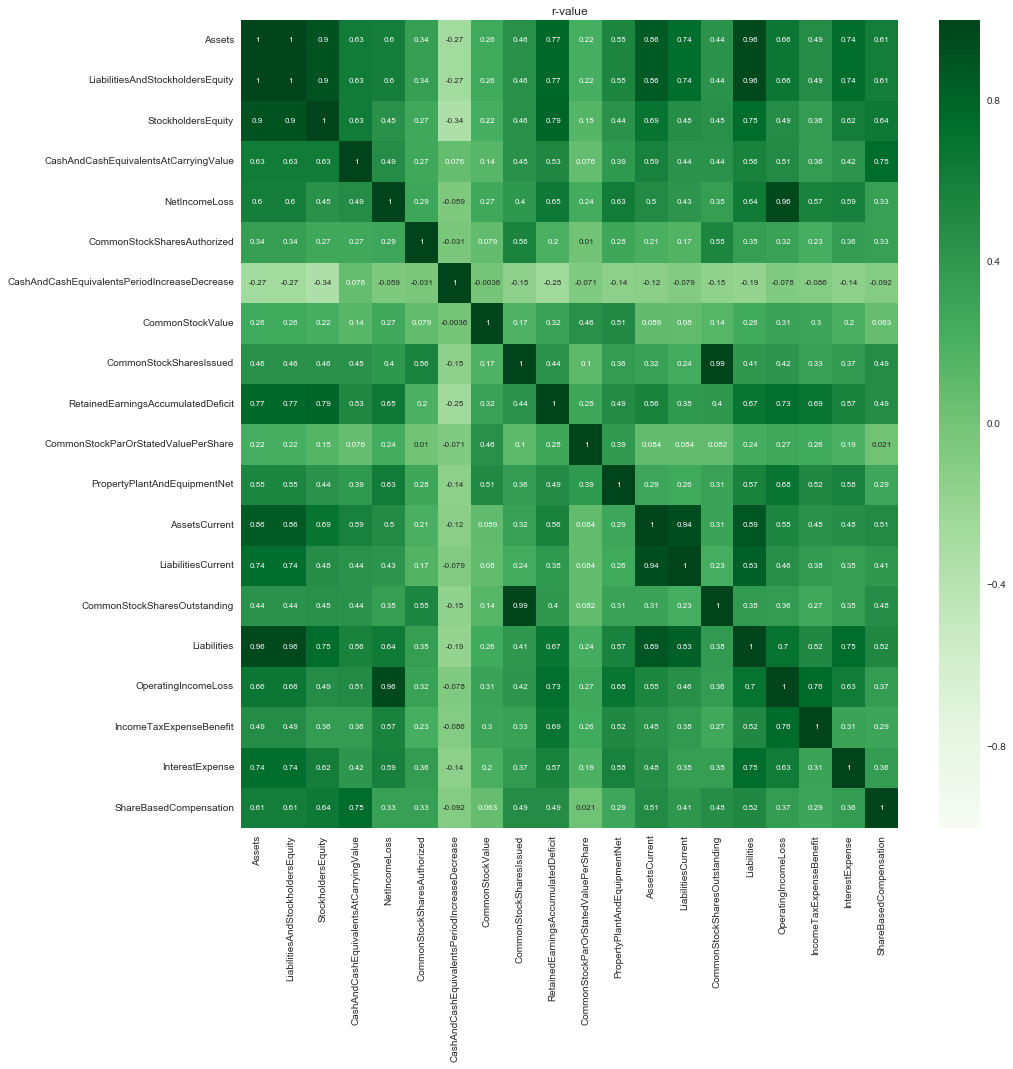

In [47]:
rvalue = DataFrame(np.nan,index=common_indicators,columns=common_indicators)
pvalue = DataFrame(np.nan,index=common_indicators,columns=common_indicators)
stderr = DataFrame(np.nan,index=common_indicators,columns=common_indicators)

for X in common_indicators:
    for Y in common_indicators:
        R = linregress(df2015[[X,Y]])
        rvalue.set_value(Y,X, R.rvalue)
        pvalue.set_value(Y,X, R.pvalue)
        stderr.set_value(Y,X, R.stderr)

def heatmap(data,title):
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(data, cmap=plt.cm.Greens,annot=True, annot_kws={"size": 8})
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

#heatmap(pvalue,'p-value') 
#heatmap(stderr,'stderr') 
heatmap(rvalue,'r-value')    

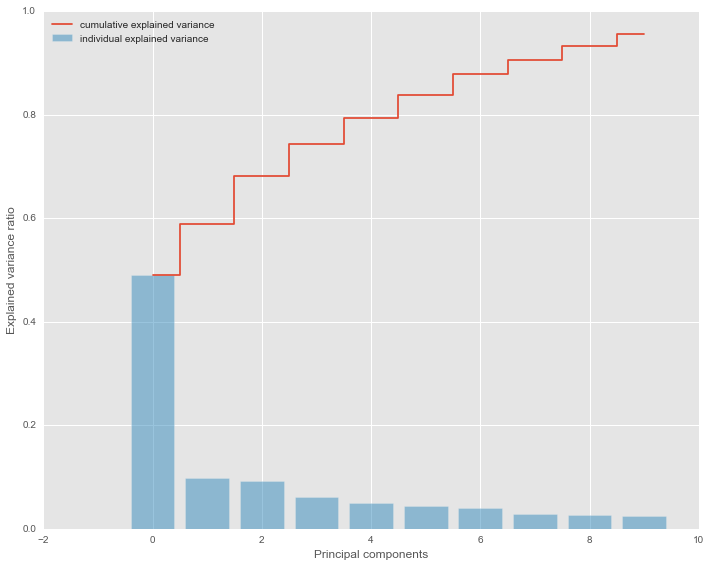

In [63]:
scaler = StandardScaler().fit(df2015[common_indicators])
scaled_values_2015 = scaler.transform(df2015[common_indicators])

var_exp=[]
cum_var_exp=[]
pca = PCA(n_components=10)
pca.fit(scaled_values_2015)
var_exp=pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('ggplot'):
    plt.figure(figsize=(10, 8))
    plt.bar(range(10), var_exp, alpha=0.5, align='center',label='individual explained variance')
    plt.step(range(10), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [64]:
pca = PCA(n_components=9)
pcscores = pd.DataFrame(pca.fit_transform(scaled_values_2015))
pcscores.columns = ['PC'+str(i+1) for i in range(len(pcscores.columns))]
pcscores.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-0.884812,0.067626,0.180003,0.121980,-0.144954,0.146082,-0.060435,-0.059861,0.051540
1,5.903422,3.858618,0.461353,-1.474513,0.978795,-0.080209,-0.567751,1.647957,-0.616772
2,-0.588954,2.072085,0.155242,-1.060796,1.579644,-0.606534,-0.815882,2.692837,-1.474722
3,-0.982405,0.301747,0.157040,-0.060364,-0.030979,0.057772,-0.144998,0.174634,-0.077163
4,-0.341745,2.082250,0.120063,-0.912287,1.639525,-0.603224,-0.815344,2.681953,-1.421344


In [65]:
pc = pd.DataFrame(pca.components_, columns=common_indicators)
pc.index = ['PC'+str(i+1) for i in range(len(pcscores.columns))]
pc.head()

,Assets,LiabilitiesAndStockholdersEquity,StockholdersEquity,CashAndCashEquivalentsAtCarryingValue,NetIncomeLoss,CommonStockSharesAuthorized,CashAndCashEquivalentsPeriodIncreaseDecrease,CommonStockValue,CommonStockSharesIssued,RetainedEarningsAccumulatedDeficit,CommonStockParOrStatedValuePerShare,PropertyPlantAndEquipmentNet,AssetsCurrent,LiabilitiesCurrent,CommonStockSharesOutstanding,Liabilities,OperatingIncomeLoss,IncomeTaxExpenseBenefit,InterestExpense,ShareBasedCompensation
PC1,0.303239,0.303239,0.266545,0.225066,0.240320,0.137739,-0.068876,0.106198,0.193848,0.262607,0.088004,0.211466,0.256796,0.218218,0.183878,0.294933,0.260205,0.202901,0.236166,0.208883
PC2,-0.087588,-0.087588,-0.145369,-0.170515,0.232660,-0.130013,0.038746,0.432840,-0.153303,0.116283,0.424051,0.353296,-0.204697,-0.184323,-0.188785,-0.040665,0.260078,0.261109,0.059867,-0.283425
PC3,0.150393,0.150393,0.063698,-0.045195,-0.023659,-0.401874,-0.020762,-0.093055,-0.507485,0.020768,-0.018391,-0.106935,0.302116,0.330988,-0.509809,0.192795,-0.016909,-0.006097,0.007135,-0.097415
PC4,-0.118695,-0.118695,-0.281099,0.246659,0.257283,0.100351,0.736660,-0.127520,-0.039256,-0.110564,-0.218263,-0.014550,0.085953,0.137434,-0.061827,-0.003456,0.248942,0.190509,-0.063706,0.052157
PC5,0.041787,0.041787,0.112503,0.311181,-0.297492,-0.146019,0.374974,0.458040,0.010030,-0.078261,0.412777,-0.004448,0.044618,0.054676,0.027666,-0.009233,-0.302101,-0.209308,-0.161869,0.288186


In [58]:
round(pca.explained_variance_ratio_.sum()*100)

93.0

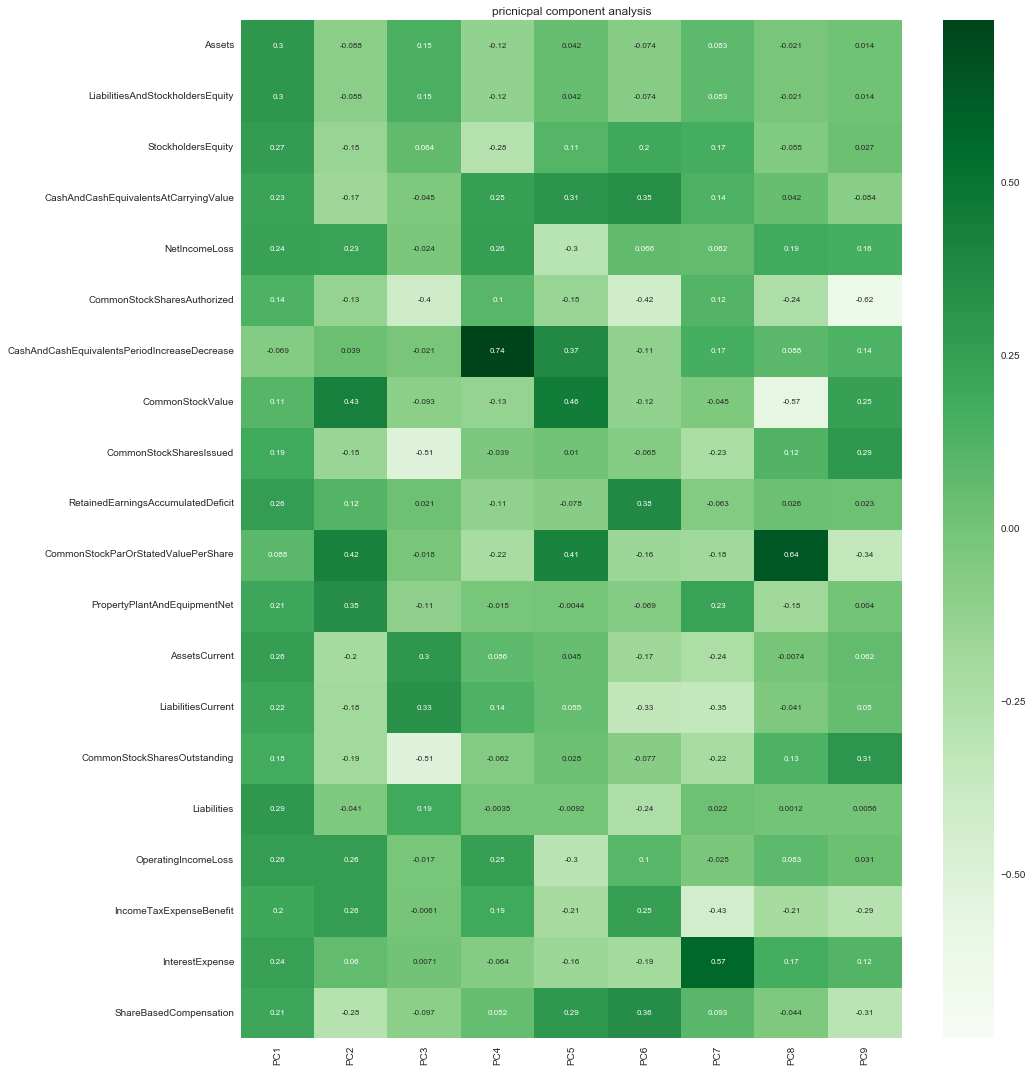

In [61]:
heatmap(pc.transpose(),'pricnicpal component analysis')